In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regular expressions
pd.set_option("display.max_colwidth", 200) 
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import warnings 
warnings.filterwarnings("ignore")

Loading Dataset

In [2]:
working_dir_path = 'Reviews.csv'
df = pd.read_csv(working_dir_path,encoding = 'latin')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


Assessing Dataset

In [3]:
df.shape

(568454, 10)

In [4]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

## Make sentiments positive that has score 4 or higher

In [5]:
df.loc[(df.Score >= 4),'Sentiment']='Positive'

## Make sentiments neutral that has score 3

In [6]:
df.loc[(df.Score == 3),'Sentiment']='Neutral'

## Make sentiments negative that has score less than or equals to 2

In [7]:
df.loc[(df.Score <= 2),'Sentiment']='Negative'

## Visualize labels, Sentiment

Positive    443777
Negative     82037
Neutral      42640
Name: Sentiment, dtype: int64

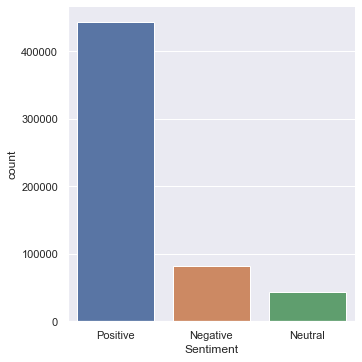

In [8]:
sns.set(font_scale=1)
sns.catplot("Sentiment", data=df, kind="count", height=5)
df['Sentiment'].value_counts()

A) Removing @user, HTTP and URLs

## Preprocessing

In [9]:
df['Text'] = df['Text'].str.lower()

A) Removing Punctuations, Numbers, and Special Characters

In [10]:
# remove special characters, numbers, punctuations
df['Text'] = df['Text'].str.replace('[^a-zA-Z#]+',' ')

B) Removing Short Words

In [11]:
# remove short words
df['Text'] = df['Text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

C) Tokenization

In [12]:
# create new variable tokenized texts
tokenized_texts = df['Text'].apply(lambda x: x.split())

D) Stemming

In [13]:
stemmer = PorterStemmer()

# apply stemmer for tokenized_tweet
tokenized_texts = tokenized_texts.apply(lambda x: [stemmer.stem(i) for i in x])

# join tokens into one sentence
for i in range(len(tokenized_texts)):
    tokenized_texts[i] = ' '.join(tokenized_texts[i])
# change df['Texts'] to tokenized_texts

df['Text']  = tokenized_texts
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,have bought sever the vital can dog food product and have found them all good qualiti the product look more like stew than process meat and smell better labrador finicki and she appreci thi produc...,Positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arriv label jumbo salt peanut the peanut were actual small size unsalt not sure thi wa error the vendor intend repres the product jumbo,Negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",thi confect that ha been around few centuri light pillowi citru gelatin with nut thi case filbert and cut into tini squar and then liber coat with powder sugar and tini mouth heaven not too chewi ...,Positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,you are look for the secret ingredi robitussin believ have found got thi addit the root beer extract order which wa good and made some cherri soda the flavor veri medicin,Negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffi great price there wa wide assort yummi taffi deliveri wa veri quick your taffi lover thi deal,Positive


Extracting Features from cleaned dataset

In [14]:
new_df = df[['Text','Sentiment']]

Removing Stopwords

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
new_df['Text'].apply(lambda x: [item for item in x if item not in stop])

0         [h, v, e,  , b, u, g, h,  , e, v, e, r,  , h, e,  , v, l,  , c, n,  , g,  , f,  , p, r, u, c,  , n,  , h, v, e,  , f, u, n,  , h, e,  , l, l,  , g,  , q, u, l,  , h, e,  , p, r, u, c,  , l, k,  , ...
1         [p, r, u, c,  , r, r, v,  , l, b, e, l,  , j, u, b,  , l,  , p, e, n, u,  , h, e,  , p, e, n, u,  , w, e, r, e,  , c, u, l,  , l, l,  , z, e,  , u, n, l,  , n,  , u, r, e,  , h,  , w,  , e, r, r, ...
2         [h,  , c, n, f, e, c,  , h,  , h,  , b, e, e, n,  , r, u, n,  , f, e, w,  , c, e, n, u, r,  , l, g, h,  , p, l, l, w,  , c, r, u,  , g, e, l, n,  , w, h,  , n, u,  , h,  , c, e,  , f, l, b, e, r, ...
3         [u,  , r, e,  , l, k,  , f, r,  , h, e,  , e, c, r, e,  , n, g, r, e,  , r, b, u, n,  , b, e, l, e, v,  , h, v, e,  , f, u, n,  , g,  , h,  ,  , h, e,  , r,  , b, e, e, r,  , e, x, r, c,  , r, e, ...
4             [g, r, e,  , f, f,  , g, r, e,  , p, r, c, e,  , h, e, r, e,  , w,  , w, e,  , r,  , u,  , f, f,  , e, l, v, e, r,  , w,  , v, e, r,  , q, u, c, k

Splitting the Dataset into Training And Testing Dataset ( For Multiclass Classification)

In [17]:
train,test = train_test_split(new_df,test_size = 0.2,random_state=0,stratify = new_df.Sentiment.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

Train shape :  (454763, 2)
Test shape :  (113691, 2)


In [18]:
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.Text.values)
X_test = vectorizer.transform(test.Text.values)

y_train = train.Sentiment.values
y_test = test.Sentiment.values

print("X_train.shape : ", X_train.shape)
print("X_test.shape : ", X_test.shape)
print("y_train.shape : ", y_train.shape)
print("y_test.shape : ", y_test.shape)

X_train.shape :  (454763, 72127)
X_test.shape :  (113691, 72127)
y_train.shape :  (454763,)
y_test.shape :  (113691,)


MULTICLASS Classification

1) Naive Bayes Classifier

In [19]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_test)
NB_accuracy = accuracy_score(y_test,NB_prediction)
print("Training accuracy Score    : ", naiveByes_clf.score(X_train,y_train))
print("Testing accuracy Score : ", NB_accuracy )
print(classification_report(NB_prediction,y_test))

Training accuracy Score    :  0.8339134890041626
Testing accuracy Score :  0.8280602686228461
              precision    recall  f1-score   support

    Negative       0.64      0.64      0.64     16614
     Neutral       0.32      0.33      0.32      8240
    Positive       0.91      0.91      0.91     88837

    accuracy                           0.83    113691
   macro avg       0.62      0.63      0.63    113691
weighted avg       0.83      0.83      0.83    113691



2) Stochastic Gradient Descent-SGD Classifier

In [20]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_test)
sgd_accuracy = accuracy_score(y_test,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Testing accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_test))

Training accuracy Score    :  0.8671066027799096
Testing accuracy Score :  0.8632257610540852
              precision    recall  f1-score   support

    Negative       0.64      0.76      0.69     13866
     Neutral       0.06      0.67      0.12       815
    Positive       0.98      0.88      0.93     99010

    accuracy                           0.86    113691
   macro avg       0.56      0.77      0.58    113691
weighted avg       0.93      0.86      0.89    113691



3) Random Forest Classifier

In [22]:
rf_clf = RandomForestClassifier()

rf_clf.fit(X_train,y_train)

rf_prediction = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test,rf_prediction)
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Testing accuracy Score : ",rf_accuracy )
print(classification_report(rf_prediction,y_test))

Training accuracy Score    :  0.9998790578828972
Testing accuracy Score :  0.8856989559419831
              precision    recall  f1-score   support

    Negative       0.53      0.97      0.69      9029
     Neutral       0.39      1.00      0.56      3308
    Positive       1.00      0.87      0.93    101354

    accuracy                           0.89    113691
   macro avg       0.64      0.95      0.73    113691
weighted avg       0.94      0.89      0.90    113691



4) Logistic Regression

In [21]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_test)
logreg_accuracy = accuracy_score(y_test,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Testing accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_test))

Training accuracy Score    :  0.8765686742325123
Testing accuracy Score :  0.8673861607339192
              precision    recall  f1-score   support

    Negative       0.67      0.76      0.71     14543
     Neutral       0.21      0.51      0.30      3593
    Positive       0.97      0.90      0.93     95555

    accuracy                           0.87    113691
   macro avg       0.62      0.72      0.65    113691
weighted avg       0.90      0.87      0.88    113691



Test Accuracies

In [23]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent'],
    'Test accuracy': [logreg_accuracy, 
              rf_accuracy, NB_accuracy, 
              sgd_accuracy]})

models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
1,Random Forest,0.885699
0,Logistic Regression,0.867386
3,Stochastic Gradient Decent,0.863226
2,Naive Bayes,0.828060


Understanding the emotions of people.

a) What are they feeling negative about?

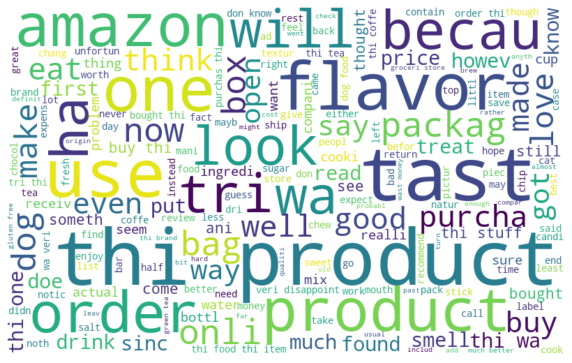

In [26]:
# import numpy as npy
# from PIL import Image

from wordcloud import WordCloud
# create text from just normal tweets
normal_words = ' '.join([text for text in new_df['Text'][new_df['Sentiment'] == 'Negative']])

# mask_virus = npy.array(Image.open('/content/drive/MyDrive/NLP Group Project/Mask.png'))
wordcloud = WordCloud(width=800, height=500, background_color = 'white', random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


b) What are they feeling positive about?

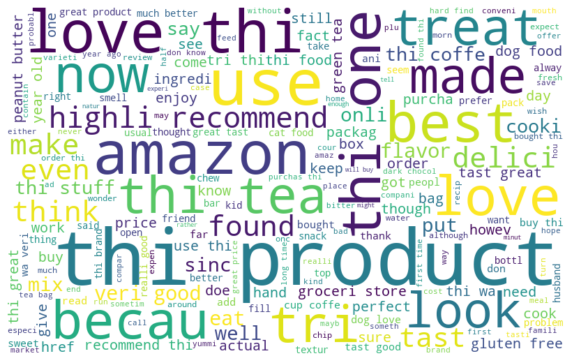

In [27]:
# create text from just normal tweets
normal_words = ' '.join([text for text in new_df['Text'][new_df['Sentiment'] == 'Positive']])

# mask_virus = npy.array(Image.open('/content/drive/MyDrive/NLP Group Project/Mask.png'))
wordcloud = WordCloud(width=800, height=500, background_color = 'white', random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


Chart for negative words

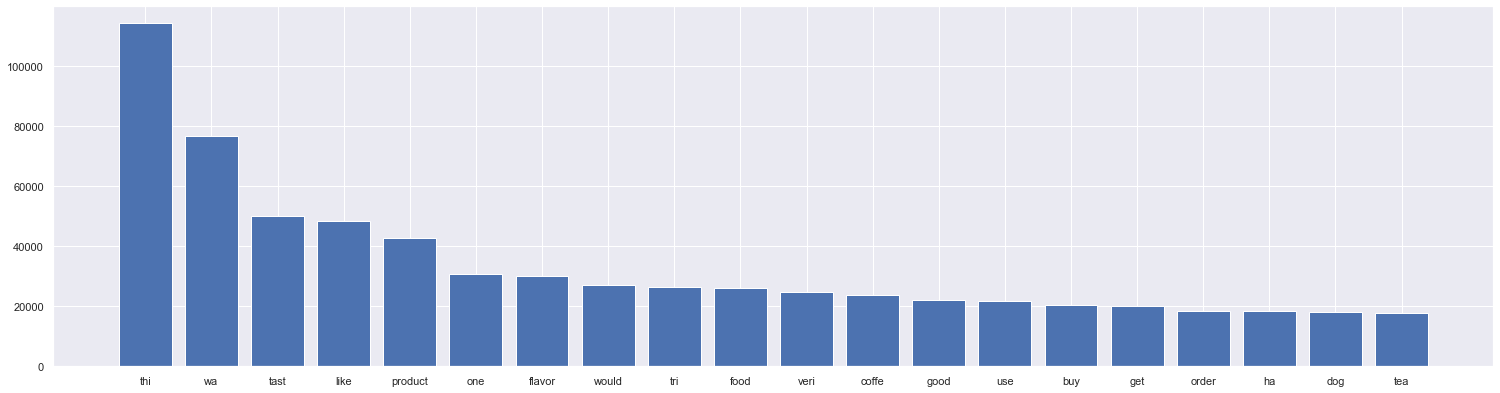

In [29]:
neg_words = ' '.join([text for text in new_df['Text'][new_df['Sentiment'] == 'Negative']]).split()

neg_words_freq = {}
stop = list(stopwords.words('english'))


for word in neg_words:
  if word not in stop:
    if word not in neg_words_freq:
      neg_words_freq[word] = 1
    else:
      neg_words_freq[word] += 1


neg_words_freq = sorted(neg_words_freq.items(), key=lambda neg_words_freq: neg_words_freq[1], reverse=True)


neg_words_freq = neg_words_freq[:20]

plt.rcParams["figure.figsize"] = (20,5)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
freqs = []
values = []

for idx,value in enumerate(neg_words_freq):
  freqs.append(value[0])
  values.append(value[1])

ax.bar(freqs,values)
plt.show()

Chart for positive words

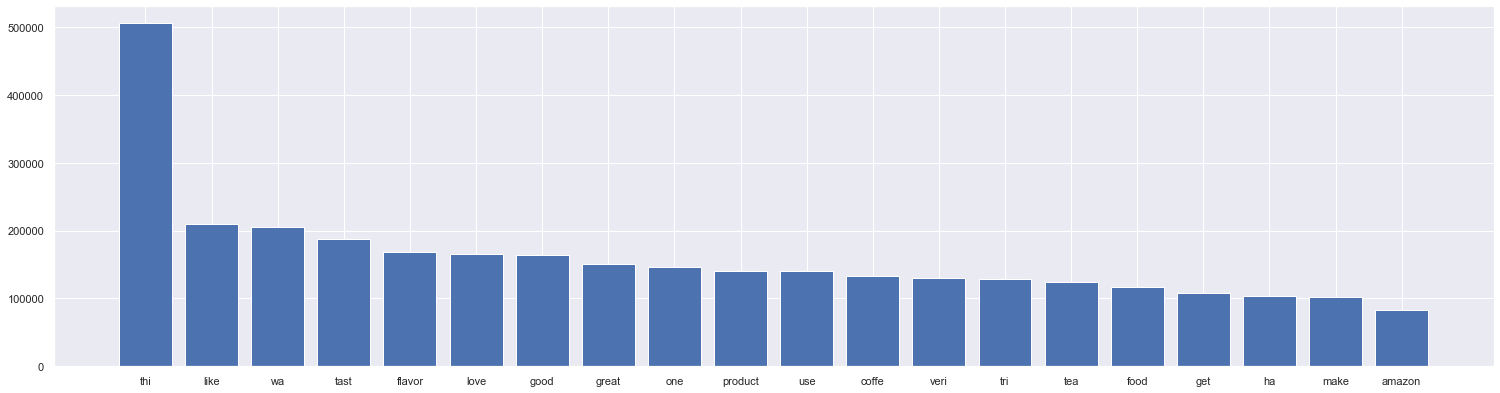

In [30]:
pos_words = ' '.join([text for text in new_df['Text'][new_df['Sentiment'] == 'Positive']]).split()

pos_words_freq = {}
stop = list(stopwords.words('english'))

for word in pos_words:
  if word not in stop:
    if word not in pos_words_freq:
      pos_words_freq[word] = 1
    else:
      pos_words_freq[word] += 1


pos_words_freq = sorted(pos_words_freq.items(), key=lambda pos_words_freq: pos_words_freq[1], reverse=True)


pos_words_freq = pos_words_freq[:20]

plt.rcParams["figure.figsize"] = (20,5)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
freqs = []
values = []

for idx,value in enumerate(pos_words_freq):
  freqs.append(value[0])
  values.append(value[1])

ax.bar(freqs,values)
plt.show()